### Estimate generalization error of Random feature model 
对于每个p值（p取4，6，8，10，12，14，16，18，20），生成大小为batch_size=100的测试集S'，取1000个w，对计算测试集上的MSE取平均

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os

os.chdir('C://Users//sunji//Documents//WeChat Files//wxid_rjlp06765c5a21//FileStorage//File//2023-10')
os.listdir('data')

['gibbs_data_p_is_10.json',
 'gibbs_data_p_is_12.json',
 'gibbs_data_p_is_14.json',
 'gibbs_data_p_is_16.json',
 'gibbs_data_p_is_18.json',
 'gibbs_data_p_is_20.json',
 'gibbs_data_p_is_4.json',
 'gibbs_data_p_is_6.json',
 'gibbs_data_p_is_8.json']

In [91]:
def generalization_MSE(w_list,p,batch_size=100):
    """ Estimate Generalization error of Random feature model.
    
    :param w_list: list of generated w for estimation 
    :param p: dimension of student model（可变）
    :param batch_size: number of test dataset S'
    :return: list of float, MSE for each w / float, MSE of random feature model with p
    """

    """
    参数设置：与训练所用teacher model保持一致（来自09-29: Gibbs.py）
    """
    original_random_state = np.random.get_state()
    np.random.seed(20230929) 
    #gaussian distribution sampler: normal(mean=0.0, variance_sqrt=1.0, size=None) s = np.random.normal(0,1)
    #teacher model
    #dimension of x: d（固定不变）10->5
    d = 5
    #number of training samples（固定不变）100->20
    N = 20
    #dimension of hypothesis space
    p0 = 5 #dimension of teacher model（固定不变）
    p = p #dimension of student model（可变）#p=200
    p_max = 2000 #upper bound of dimension of student model（固定不变）
    #point-wise activate function f:tanh
    #variance of random noise added to y
    sigma = 0.1

    #random feature matrix
    F0 = np.random.normal(0,1,(d,p0)) #生成teacher model的random feature matrix F0（固定不变）
    F = np.random.normal(0,1,(d,p_max))[:,:p] #生成student model的random feature matrix F(d*p)。先按照p_max的大小生成，再根据当前维度p的不同截取前p列形成每个p对应的F。
        #注意，这个F对于一般的神经网络是可训练的，但是对于RFM为了简化直接设定为固定值。（固定不变）
    #teacher parameter w(p) with lambda = ? until each dim of Y~1e0
    lambda_ = 0.0001
    #w_0 = np.random.normal(0,sigma/np.sqrt(lambda_*N),p)
    w_0 = np.random.normal(0,1,p0) #生成teacher model的权重向量（固定不变）
    #w_0 = np.concatenate((w_0,np.zeros(5)),axis = 0)
    
    np.random.set_state(original_random_state)
    np.random.seed(20231004+p) #每个p用不同的随机种子,对应不同随机固定的测试集
    
    MSE_list=[]
    for w in w_list:
        error_list=[]
        for _ in range(batch_size):
            '''
            采样测试集S'：每次测试集重新生成，此处采样一个S=(X,Y)
                 采样X(N*d)，X经过F0和w_0作用后再加上高斯扰动（这个扰动是必要的，不然构成确定映射不影响互信息）形成Y，
                 Y与X一起构成了从dataset里采样的N个样本，对应了论文中的=>S （可变）
            '''
            #samples X(N*d) 
            X = np.random.normal(0,1,(N,d)) #生成N个d维随机向量，作为N条样本组成的训练集。
            #X after the random feature matrix
            X_rf0 = np.tanh(X.dot(F0)/np.sqrt(d))
            Y_pure = X_rf0.dot(w_0)
            Y = Y_pure + np.random.normal(0,sigma,N) #由X通过teacher model（也就是F0和w_0）生成的Y

            '''
            w预测：X经过F和w_0作用形成pred_Y，泛化误差mse:E[（Y-pred_Y）^2]
            '''
            X_rf = np.tanh(X.dot(F)/np.sqrt(d))
            diff = Y-X_rf.dot(w)
            error_list.append(diff.dot(diff))
        
        MSE_list.append(sum(error_list)/batch_size)
        
    return MSE_list,sum(MSE_list)/len(MSE_list)

### result

In [86]:
#param
w_num = 1000
test_size = 100

generalization_error=[]
for p_current in range(4,22,2):
    with open('data/gibbs_data_p_is_{}.json'.format(p_current), 'r') as datafile:
        data = json.load(datafile)
    w_sample=[dist['w'] for dist in data[:w_num]]
    
    g_error=generalization_MSE(w_sample,p_current,test_size)[1]
    generalization_error.append(g_error)
    print('p={},generalization error={}'.format(p_current,g_error))

p=4,generalization error=2.63877764604716
p=6,generalization error=1.087845679776619
p=8,generalization error=1.1894750397069953
p=10,generalization error=1.2414590046550829
p=12,generalization error=1.2679941415989733
p=14,generalization error=1.2448360859695546
p=16,generalization error=1.294578818387506
p=18,generalization error=1.2898312736442472
p=20,generalization error=1.2718211215705624


Text(0, 0.5, 'mse')

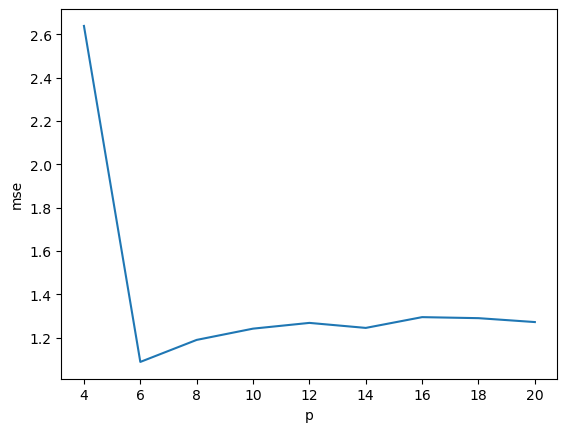

In [88]:
plt.figure()
plt.plot(range(4,22,2), generalization_error)
plt.xlabel('p')
plt.ylabel('mse')

p=4,generalization error=2.633300721232373
p=6,generalization error=1.086564037262704
p=8,generalization error=1.1911882796468014
p=10,generalization error=1.2452612061596797
p=12,generalization error=1.2687666022096746
p=14,generalization error=1.2415690091993756
p=16,generalization error=1.2957209683082849
p=18,generalization error=1.2899560812848772
p=20,generalization error=1.2709478147117843


Text(0.5, 1.0, 'Generalization_error (w_num = 1000,test_size = 1000)')

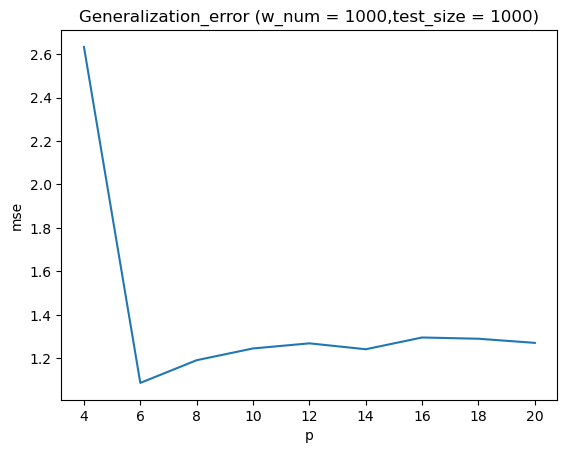

In [95]:
#param
w_num = 1000
test_size = 1000

generalization_error=[]
for p_current in range(4,22,2):
    with open('data/gibbs_data_p_is_{}.json'.format(p_current), 'r') as datafile:
        data = json.load(datafile)
    w_sample=[dist['w'] for dist in data[:w_num]]
    
    g_error=generalization_MSE(w_sample,p_current,test_size)[1]
    generalization_error.append(g_error)
    print('p={},generalization error={}'.format(p_current,g_error))
    
plt.plot(range(4,22,2), generalization_error)
plt.xlabel('p')
plt.ylabel('mse')
plt.title('Generalization_error (w_num = 1000,test_size = 1000)')

In [ ]:
#param
w_num = 2000
test_size = 2000

generalization_error=[]
for p_current in range(4,22,2):
    with open('data/gibbs_data_p_is_{}.json'.format(p_current), 'r') as datafile:
        data = json.load(datafile)
    w_sample=[dist['w'] for dist in data[:w_num]]
    
    g_error=generalization_MSE(w_sample,p_current,test_size)[1]
    generalization_error.append(g_error)
    print('p={},generalization error={}'.format(p_current,g_error))
    
plt.plot(range(4,22,2), generalization_error)
plt.xlabel('p')
plt.ylabel('mse')
plt.title('Generalization_error (w_num = 1000,test_size = 1000)')

### Tuning hyperparameters

In [90]:
p_current=4
with open('data/gibbs_data_p_is_{}.json'.format(p_current), 'r') as datafile:
    data = json.load(datafile)

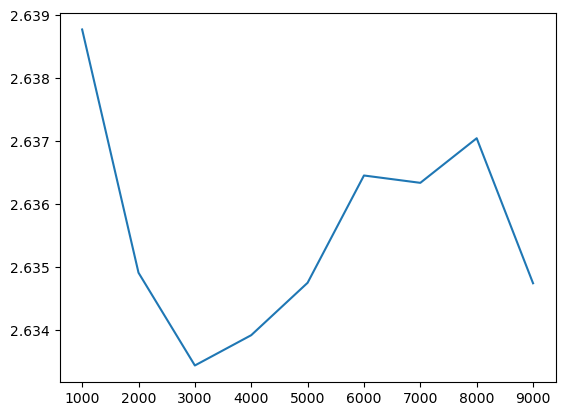

In [79]:
#测试集大小取100，p=4,观察w数量对泛化误差的影响

x_plot = [x for x in range(1000,10000,1000)]
plt.plot(x_plot, [generalization_MSE([dist['w'] for dist in data[:x]],4,100)[1] for x in x_plot])

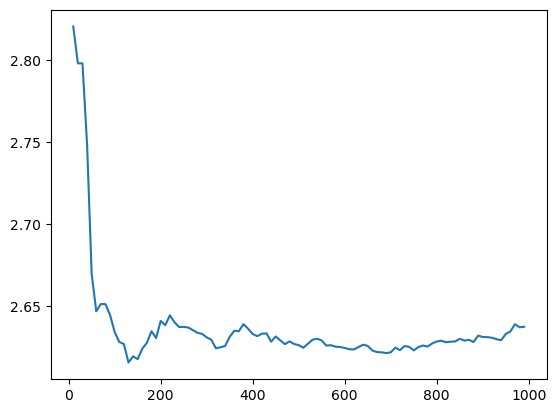

In [81]:
#测试集大小取100，p=4,观察w数量对泛化误差的影响
x_plot = [x for x in range(10,1000,10)]
plt.plot(x_plot, [generalization_MSE([dist['w'] for dist in data[:x]],4,100)[1] for x in x_plot])

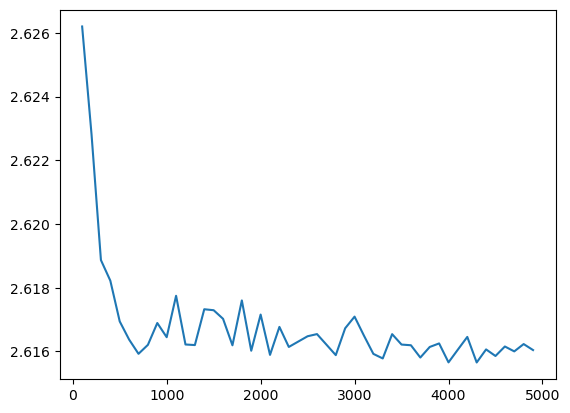

In [92]:
#w取500，p=4,观察测试集大小对泛化误差的影响

test_w = [dist['w'] for dist in data[:500]]

x_plot = [x for x in range(100,5000,100)]
plt.plot(x_plot, [generalization_MSE(test_w,4,x)[1] for x in x_plot])